In [14]:
from pathlib import Path
import sys
import numpy as np
from collections import defaultdict
import torch
from torch.utils.tensorboard import SummaryWriter
from rl_envs.gym_grid_world_env import GridWorldEnv
import numpy as np
from tools.helper import *
# from rl_envs.episodic_grid_world_env import EpisodicGridWorldEnv
# from rl_envs.grid_world_env import GridWorldEnv
from ReplayMemory import *
from agents.DQN import DeepQLearningAgent
%load_ext autoreload 
# %aimport rl_envs.grid_world_env

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:

def print_actions(agent, env, get_optimal = False):
    with torch.no_grad():
        action_mapping = [" ↓ "," ↑ "," → "," ← "," ↺ "]
        for i in range(env.height):
            print("[", end=" ")
            for j in range(env.width):
                state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
                action = agent.get_action(state)
                print(action_mapping[action.item()], end=" ")
            print("]")

def state_normalize(env, state):
    return ((state[0] - (env.height-1)/2.0)/env.height,(state[1] - (env.width-1)/2.0)/env.width)




BATCHSIZE = 100
LEARN_RATE = 1e-4 # change to 1e-4
TRUE_RANDOM_STATE_VALUE = [
    [-3.8, -3.8, -3.6, -3.1, -3.2],
    [-3.8, -3.8, -3.8, -3.1, -2.9],
    [-3.6, -3.9, -3.4, -3.2, -2.9],
    [-3.9, -3.6, -3.4, -2.9, -3.2],
    [-4.5, -4.2, -3.4, -3.4, -3.5],         
]

def calculate_state_value_error(env:GridWorldEnv,agent):
    # offline policy have 2 policies, I am using the behavior(random) policy for calculating
    with torch.no_grad():
        state_value_error = 0
        for i in range(env.height):
            for j in range(env.width):
                state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
                output = agent.policy_net(state)
                state_value = output.sum()/env.action_n
                state_value_error += (state_value - TRUE_RANDOM_STATE_VALUE[i][j])
    return state_value_error




In [25]:

env = GridWorldEnv(fixed_map = True, forbidden_grids=[(1,1),(1,2), (2,2),(3,1),(3,3),(4,1)], target_grids=[(3,2)], forbidden_reward=-10, hit_wall_reward=-10, target_reward=1)
agent = DeepQLearningAgent(state_space_n= 2, action_space_n=env.action_n, lr = LEARN_RATE)
writer = SummaryWriter()


In [17]:
"""
generate samples to replay buffer
"""
replay_buffer = ReplayMemory(100000)

episode_num = 1000
for _ in range(episode_num):
    state, info = env.reset()
    for _ in range(100):
        action = random.randint(0,int(env.action_n)-1)
        # action = agent.get_behavior_acion(state)
        next_state, reward, terminated , truncated, info = env.step(action)
        # replay_buffer.push(torch.tensor(state_normalize(env,state), dtype=torch.float), torch.tensor(action, dtype=torch.int64).unsqueeze(0), torch.tensor(reward, dtype=torch.float).unsqueeze(0), torch.tensor(state_normalize(env,next_state), dtype=torch.float))
        replay_buffer.push(torch.tensor(state['agent'], dtype=torch.float), torch.tensor(action, dtype=torch.int64).unsqueeze(0), torch.tensor(reward, dtype=torch.float).unsqueeze(0), torch.tensor(next_state['agent'], dtype=torch.float))
        state = next_state
        if terminated or truncated:
            break


In [18]:
"""
for each step:
    collect replay buffer (4 step)
        initailly, collect 100 step randomly before learning start (warmup phase)
        collect based on random initially and then sometimes on policy with episode increase
            this is based on a learning_starts
        sync target network for each step
    train on 
"""

'\nfor each step:\n    collect replay buffer (4 step)\n        initailly, collect 100 step randomly before learning start (warmup phase)\n        collect based on random initially and then sometimes on policy with episode increase\n            this is based on a learning_starts\n        sync target network for each step\n    train on \n'

In [26]:



"""
perform DQN
"""
# iter_counter = 0
# q_value = target_value = loss = []
for iter_counter in range(100000):
    transitions  = replay_buffer.sample(BATCHSIZE)
    batch = Transition(*zip(*transitions))
    state = torch.stack(batch.state)
    next_state = torch.stack(batch.next_state)
    reward = torch.cat(batch.reward)
    action_indices = torch.cat(batch.action)
    
    loss, q_value, target_value = agent.update_Q_network(state, action_indices, reward, next_state)

    if iter_counter % 50 == 0:
        # copy target network every C=50 iteration
        # state_value_estimated = output.sum(dim=1) / env.action_n 
        writer.add_scalar('TD error', (q_value - target_value).sum(), iter_counter)         
        writer.add_scalar('Loss', loss.sum(), iter_counter)
        writer.add_scalar('State value error', calculate_state_value_error(env,agent), iter_counter)


        # iter_counter+=1
        # agent.target_net.load_state_dict(agent.policy_net.state_dict())
        agent.sync_target_network()
        print(iter_counter)
    # print(loss)

writer.flush()
writer.close()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000
10050
10100
10150

In [20]:

print(env)

print_actions(agent, env, True)

print()

for i in range(env.height):
    print("[", end=" ")
    for j in range(env.width):
        state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
        output = agent.policy_net(state)
        state_value = output.sum()/env.action_n
        state_value_error = (state_value - TRUE_RANDOM_STATE_VALUE[i][j])
        print(state_value_error, end=" ")
    print("]")

# print()


<GridWorldEnv instance>
[  ↑   ↺   ↑   ←   ↺  ]
[  ↓   →   →   →   ↓  ]
[  →   ←   ↑   →   →  ]
[  →   ←   ↑   ←   ↺  ]
[  ↺   ↑   ↑   ←   ↺  ]

[ tensor(0.0044, grad_fn=<SubBackward0>) tensor(-0.0388, grad_fn=<SubBackward0>) tensor(-0.0054, grad_fn=<SubBackward0>) tensor(-0.1629, grad_fn=<SubBackward0>) tensor(-0.1923, grad_fn=<SubBackward0>) ]
[ tensor(-0.0619, grad_fn=<SubBackward0>) tensor(0.2987, grad_fn=<SubBackward0>) tensor(1.0142, grad_fn=<SubBackward0>) tensor(0.8794, grad_fn=<SubBackward0>) tensor(0.8974, grad_fn=<SubBackward0>) ]
[ tensor(-0.3263, grad_fn=<SubBackward0>) tensor(0.0406, grad_fn=<SubBackward0>) tensor(0.3464, grad_fn=<SubBackward0>) tensor(0.6739, grad_fn=<SubBackward0>) tensor(0.7523, grad_fn=<SubBackward0>) ]
[ tensor(-0.9132, grad_fn=<SubBackward0>) tensor(-1.1443, grad_fn=<SubBackward0>) tensor(-0.1136, grad_fn=<SubBackward0>) tensor(0.1500, grad_fn=<SubBackward0>) tensor(0.6795, grad_fn=<SubBackward0>) ]
[ tensor(-1.2390, grad_fn=<SubBackward0>) tensor(-

In [21]:
Q = {}
for i in range(env.size):
    for j in range(env.size):
    #    state = (y,x)
        state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
        q_values = agent.policy_net(state)
        Q[(i,j)] = q_values
print_by_dict(env,Q)
                                                                                                                                                                                                                     
                                 

[ tensor([[-0.1089,  0.4115, -9.7555, -9.7750,  0.2497]],
       grad_fn=<AddmmBackward0>) tensor([[-10.1435,  -0.0634,  -9.4708,   0.0720,   0.4118]],
       grad_fn=<AddmmBackward0>) tensor([[-9.6499,  0.9126, -9.9308,  0.3354,  0.3056]],
       grad_fn=<AddmmBackward0>) tensor([[-3.9951, -1.9513, -9.9486, -0.1435, -0.2760]],
       grad_fn=<AddmmBackward0>) tensor([[ 0.1871, -9.1468, -9.4444,  0.5889,  0.8538]],
       grad_fn=<AddmmBackward0>) ]
[ tensor([[  0.3484,  -9.8993,   0.2713, -10.0406,   0.0104]],
       grad_fn=<AddmmBackward0>) tensor([[-1.9697e+00, -4.2842e+00,  6.9585e-03, -1.0389e+00, -1.0221e+01]],
       grad_fn=<AddmmBackward0>) tensor([[-3.7672, -0.1812, -0.0791, -2.2544, -7.6470]],
       grad_fn=<AddmmBackward0>) tensor([[-2.0762, -2.9599,  0.0053, -2.8333, -3.2387]],
       grad_fn=<AddmmBackward0>) tensor([[ 0.4622, -9.6592,  0.0484, -0.7694, -0.0950]],
       grad_fn=<AddmmBackward0>) ]
[ tensor([[ -0.4921,  -8.8069,   0.0830, -10.2413,  -0.1739]],
       gr

In [22]:
V = {}
for state in Q.keys():
    V[state] = torch.max(Q[state]).item()
print_by_dict(env, V)


[ 0.41 0.41 0.91 -0.14 0.85 ]
[ 0.35 0.01 -0.08 0.01 0.46 ]
[ 0.08 0.04 -0.70 -0.22 0.68 ]
[ -0.16 -0.14 0.55 -1.08 0.36 ]
[ -0.27 0.28 0.86 0.31 0.59 ]


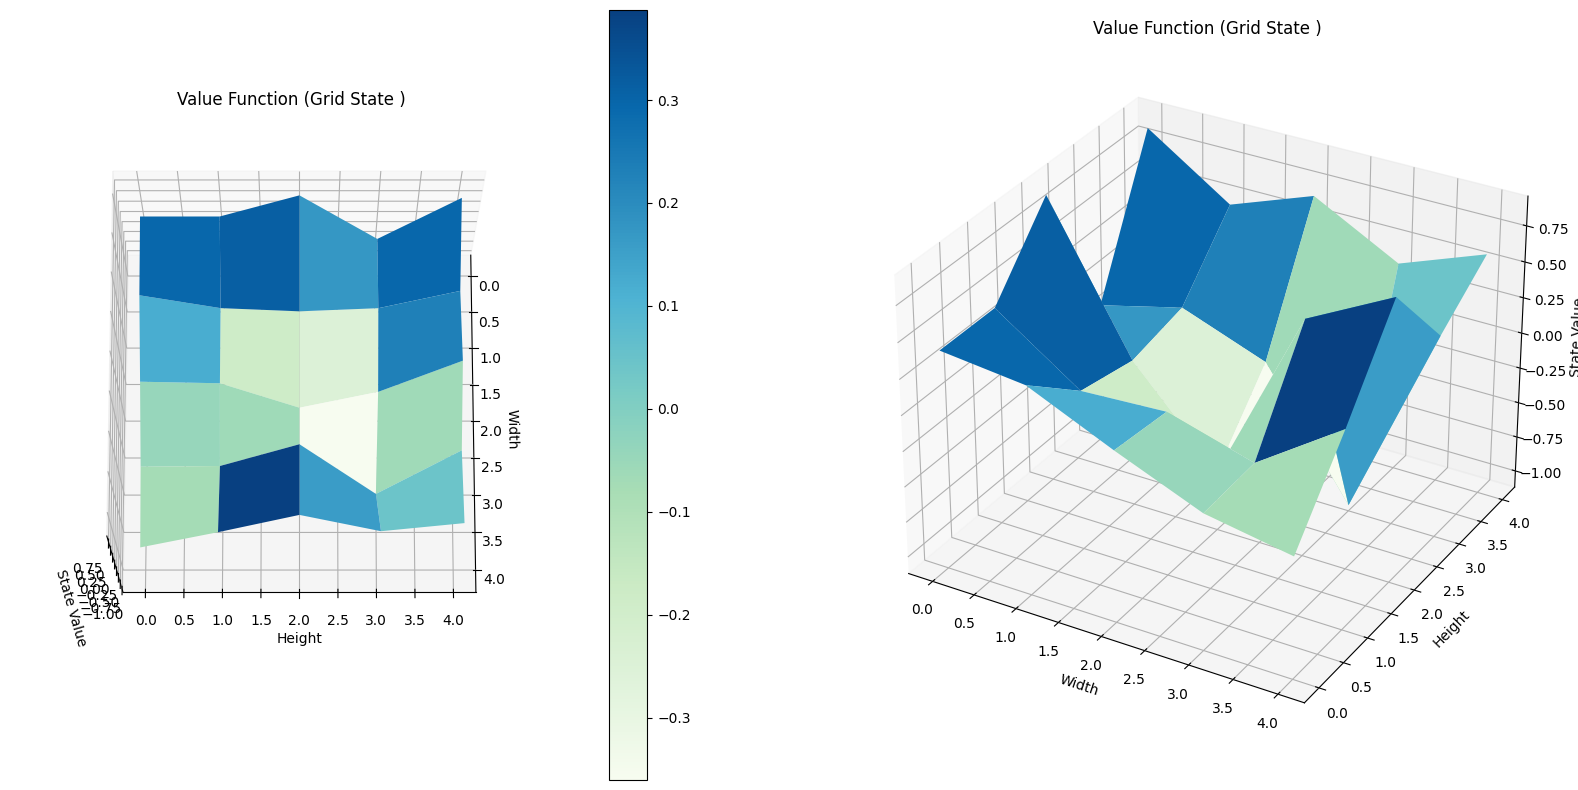

In [23]:
plot_value_function(V)
